# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Extract features and labels from the raw meta-analysis file

In [3]:
# load up our dataset
raw = pd.read_csv("../data/raw.csv", index_col=[0, 3])
raw.iloc[:5, :20]

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw.csv'

In [ ]:
# Select the taxonomic features
X = raw.iloc[:, 15:]

# Select the health status labels 
y = raw[["PHENOTYPE:Healthy_Nonhealthy"]] == "Healthy"

# Select the full phenotype labels
y_all = raw[["PHENOTYPE_Disease"]]

# Remove bad samples 

In [ ]:
non_illumina = [
    "454 GS FLX Titanium",
    "Ion Torrent PGM",
    "Ion Torrent Proton",
    "BGISEQ-500",
]

In [ ]:
# Find the indices of samples we would like to remove

remove = (
    
    # we don't need a biomarker for obesity/underweight
    (y_all == "Underweight").values.flatten() | 
    (y_all == "Overweight").values.flatten() |
    (y_all == "Obesity").values.flatten() |
    (y_all == "Obese").values.flatten() |
    
    # to reduce batch effects, remove samples sequenced with non-illumina machines
    raw["Sequencing Platform"].isin(non_illumina).values.flatten() |
    
    # all of these studies have some issue
    (y_all.index.get_level_values(0) == "P4") | # P4 treats the poop for extracting viral DNA
    (y_all.index.get_level_values(0) == "P86") | # Healthy at baseline but half develop T2D 
    (y_all.index.get_level_values(0) == "GMHI-19") | # Outlier study
    ((y_all.index.get_level_values(0) == "P48") & (y_all == "Healthy").values.flatten()) | # Alcohol or smoking
    (y_all.index.get_level_values(0) == "P59") | # Are all technically healthy, but half are in heavily urbanized areas
    # and "Microbes with higher relative abundance in Chinese urban samples have been associated with disease in other studies"
    (y_all.index.get_level_values(0) == "P63") # Deals with semisupercentenarians, i.e., 105 to 109 years old
    )

In [ ]:
# remove bad samples
X, y, y_all, raw = X.iloc[~remove, :], y.iloc[~remove, :], y_all.iloc[~remove, :], raw.iloc[~remove, :]

In [ ]:
# normalize relative abundances
X = X.divide((100 - X["UNKNOWN"]), axis="rows")

In [ ]:
# we don't need unknown column anymore
X = X.drop(labels=["UNKNOWN"], axis=1)

print(f"Our dataset has {X.shape[0]} samples with {X.shape[1]} unique taxnomic features")
print(f"Our dataset has {len(np.unique(X.index.get_level_values(0)))} independent studies")

In [ ]:
# there are 7 taxonomic ranks, each one should sum to 1, so sum of each sample should be 7 (w/ floating point error)
X.sum(axis=1)

# Evaluate our model with leave-one-study-out cross-validation

In [ ]:
# indentify groups to partition dataset

sample_studies = np.array(X.index.get_level_values(0))
o = OrdinalEncoder()
groups = o.fit_transform(sample_studies.reshape((len(sample_studies), 1))).flatten()
logo = LeaveOneGroupOut()

In [ ]:
regularization = 0.03

# establish a cutoff threshold for presence/absence
cutoff = 0.00001

# instantiate the logistic regression classifier
clf = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=regularization, class_weight="balanced")

# generate logit predictions for each left out study
GMHI2_scores = cross_val_predict(clf, X > cutoff, y.values.flatten(), method="decision_function",
    groups=groups, cv=logo, verbose=2, n_jobs=-1
)

GMHI2_scores = pd.DataFrame(GMHI2_scores, index=y.index, columns=["GMHI2"])

In [ ]:
print("GMHI2 Raw balanced accuracy:", balanced_accuracy_score(y, GMHI2_scores > 0)) 
thresh = 0.1
idx = abs(GMHI2_scores.values) > thresh
print(f"GMHI2 balanced accuracy for |GMHI2| > {thresh}:", balanced_accuracy_score(y[idx], GMHI2_scores[idx] > 0))

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import pandas as pd
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

"""
Class that implements the GMHI algorithm. Extends sklearn base estimator for
cross validation compatibility
"""


class GMHI(BaseEstimator):

    def __init__(self, use_shannon=False, theta_f=1, theta_d=0):
        self.use_shannon = use_shannon
        self.fitted = False
        self.thresh = 0.00001
        self.health_abundant = None
        self.health_scarce = None
        self.features = None
        self.theta_f = theta_f
        self.theta_d = theta_d

    def fit(self, X, y):
        """
        Identifies health_abundant and health_scarce
        columns/features
        """
        self.features = X.columns
        self.classes_ = np.unique(y)
        if(isinstance(X, pd.DataFrame)):
            X = X.values
        if(isinstance(y, pd.DataFrame)):
            y = y.values
        self.fitted = True
        difference, fold_change = self.get_proportion_comparisons(X, y)
        self.select_features(difference, fold_change)

    def get_proportion_comparisons(self, X, y):
        # get healthy and unhealthy samples
        healthies = X[y.flatten(), :]
        unhealthies = X[~y.flatten(), :]

        # get proportions for each species
        proportion_healthy = self.get_proportions(healthies)
        proportion_unhealthy = self.get_proportions(unhealthies)

        # get differences and fold change
        diff = proportion_healthy - proportion_unhealthy
        fold = proportion_healthy / proportion_unhealthy
        return diff, fold

    def get_proportions(self, samples_of_a_class):
        num_samples = samples_of_a_class.shape[0]
        p = np.sum(samples_of_a_class > self.thresh, axis=0) / num_samples
        return p

    def select_features(self, difference, fold_change):
        # based on proportion differences and fold change, select health abundant
        # and health scarce
        self.health_abundant = self.features[self.cutoff(difference, fold_change)]
        self.health_scarce = self.features[self.cutoff(-1 * difference, 1 / fold_change)]

    def cutoff(self, diff, fold):
        diff_cutoff = diff > self.theta_d
        fold_cutoff = fold > self.theta_f
        both_cutoff = np.bitwise_and(diff_cutoff, fold_cutoff)
        columns = np.where(both_cutoff)
        return columns[0]

    def decision_function(self, X):
        if not self.fitted:
            return None
        if list(X.columns) != list(self.features):
            raise Exception("Model was trained with (different) feature names than input")
        # if(isinstance(X, pd.DataFrame)):
        #    X = X.values
        X_healthy_features = X[self.health_abundant]
        X_unhealthy_features = X[self.health_scarce]
        psi_MH = self.get_psi(X_healthy_features.values) / (
            X_healthy_features.shape[1])
        psi_MN = self.get_psi(X_unhealthy_features.values) / (
            (X_unhealthy_features.shape[1]))
        num = psi_MH + self.thresh
        dem = psi_MN + self.thresh
        return np.log10(num / dem)

    def get_psi(self, X):
        psi = self.richness(X) * 1.0
        if self.use_shannon:
            shan = self.shannon(X)
            psi *= shan
        return psi

    def richness(self, X):
        """
        Returns the number of nonzero values for each sample (row) in X
        """
        rich = np.sum(X > self.thresh, axis=1)
        return rich

    def shannon(self, X):
        logged = np.log(X)
        logged[logged == -np.inf] = 0
        logged[logged == np.inf] = 0
        shan = logged * X * -1
        return np.sum(shan, axis=1)

    def predict(self, X):
        return self.decision_function(X) > 0

In [ ]:
X_species = X[filter(lambda x : "s__" in x and "virus" not in x and "unclassified" not in x, list(X.columns))]
X_freq = np.mean(X_species > cutoff, axis=0)
more_than_1p = (X_freq >= 0.1).values
X_GMHI = X_species.iloc[:, more_than_1p]

In [ ]:
# generate GMHI scores for each left out study
GMHI_scores = pd.DataFrame(np.zeros(y.shape), index=y.index, columns=["GMHI"])

studies = X.index.get_level_values(0)

for study in np.unique(studies):
    train_studies = list(set(studies) - set(study))
    
    # get train-test split
    X_train = X_GMHI.loc[train_studies]
    X_test = X_GMHI.loc[study]
    y_train = y.loc[train_studies]
    y_test = y.loc[study]
    
    # instantiate the GMHI model
    clf = GMHI(use_shannon=True, theta_f=1.4, theta_d=0.1)
    clf.fit(X_train, y_train)
    study_GMHIs = clf.decision_function(X_test)
#     print(balanced_accuracy_score(y_test, study_GMHIs > 0))
    
    GMHI_scores.loc[study] = np.expand_dims(study_GMHIs, axis=-1)

In [4]:
print("GMHI Raw balanced accuracy:", balanced_accuracy_score(y, GMHI_scores > 0)) 
thresh = 0.1
idx = abs(GMHI_scores.values) > thresh
print(f"GMHI balanced accuracy for |GMHI| > {thresh}:", balanced_accuracy_score(y[idx], GMHI_scores[idx] > 0))

NameError: name 'y' is not defined

In [5]:
plt.style.use('default')



from matplotlib import rc
from matplotlib.patches import Patch

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


In [6]:
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [7]:
def plot_pca(X, y):
    # set colors
    healthy_color = "steelblue"
    nonhealthy_color = 'orange'
    
    # Perform dimensionality reduction
    pca = PCA(random_state=42, n_components=2)
    cutoff = 0.00001
    pca.fit(X > cutoff)
    PC1_variance, PC2_variance = pca.explained_variance_[:2]
    embedding = pca.transform(X > cutoff)
    
    # plot pca
    plt.figure(figsize=(10, 10), dpi=200)
    PC1_healthy, PC2_healthy = embedding[y.values.flatten(), 0], embedding[y.values.flatten(), 1]
    PC1_nonhealthy, PC2_nonhealthy = embedding[~y.values.flatten(), 0], embedding[~y.values.flatten(), 1]
    alpha = 1
    s = 10
    plt.scatter(PC1_healthy, PC2_healthy, alpha=alpha, s=s, label="Healthy", color=healthy_color)
    plt.scatter(PC1_nonhealthy, PC2_nonhealthy, alpha=alpha, s=s, label="Nonhealthy", color=nonhealthy_color)
    n_std = 2.25
    
    # plot ellipses
    confidence_ellipse(PC1_healthy, PC2_healthy, plt.gca(), n_std=n_std,
                       alpha=1, edgecolor=healthy_color, lw=2)
    confidence_ellipse(PC1_healthy, PC2_healthy, plt.gca(), n_std=n_std,
                       alpha=0.2, facecolor=healthy_color)
    
    confidence_ellipse(PC1_nonhealthy, PC2_nonhealthy, plt.gca(), n_std=n_std,
                       alpha=1, edgecolor=nonhealthy_color, lw=2)
    confidence_ellipse(PC1_nonhealthy, PC2_nonhealthy, plt.gca(), n_std=n_std,
                       alpha=0.2, facecolor=nonhealthy_color)
    
    
    plt.xlabel(f"PC1 ({'{:.2f}'.format(PC1_variance)}\%)", fontsize=20)
    plt.ylabel(f"PC2 ({'{:.2f}'.format(PC2_variance)}\%)", fontsize=20)
    
    
    handles = [
        Patch(facecolor=healthy_color, edgecolor="k", label="Healthy", alpha=0.7),
        Patch(facecolor=nonhealthy_color, edgecolor="k", label="Nonhealthy", alpha=0.7),
    ]
    
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(handles=handles, prop={'size': 14}, loc=2, handlelength=1.4, handleheight=1.4)

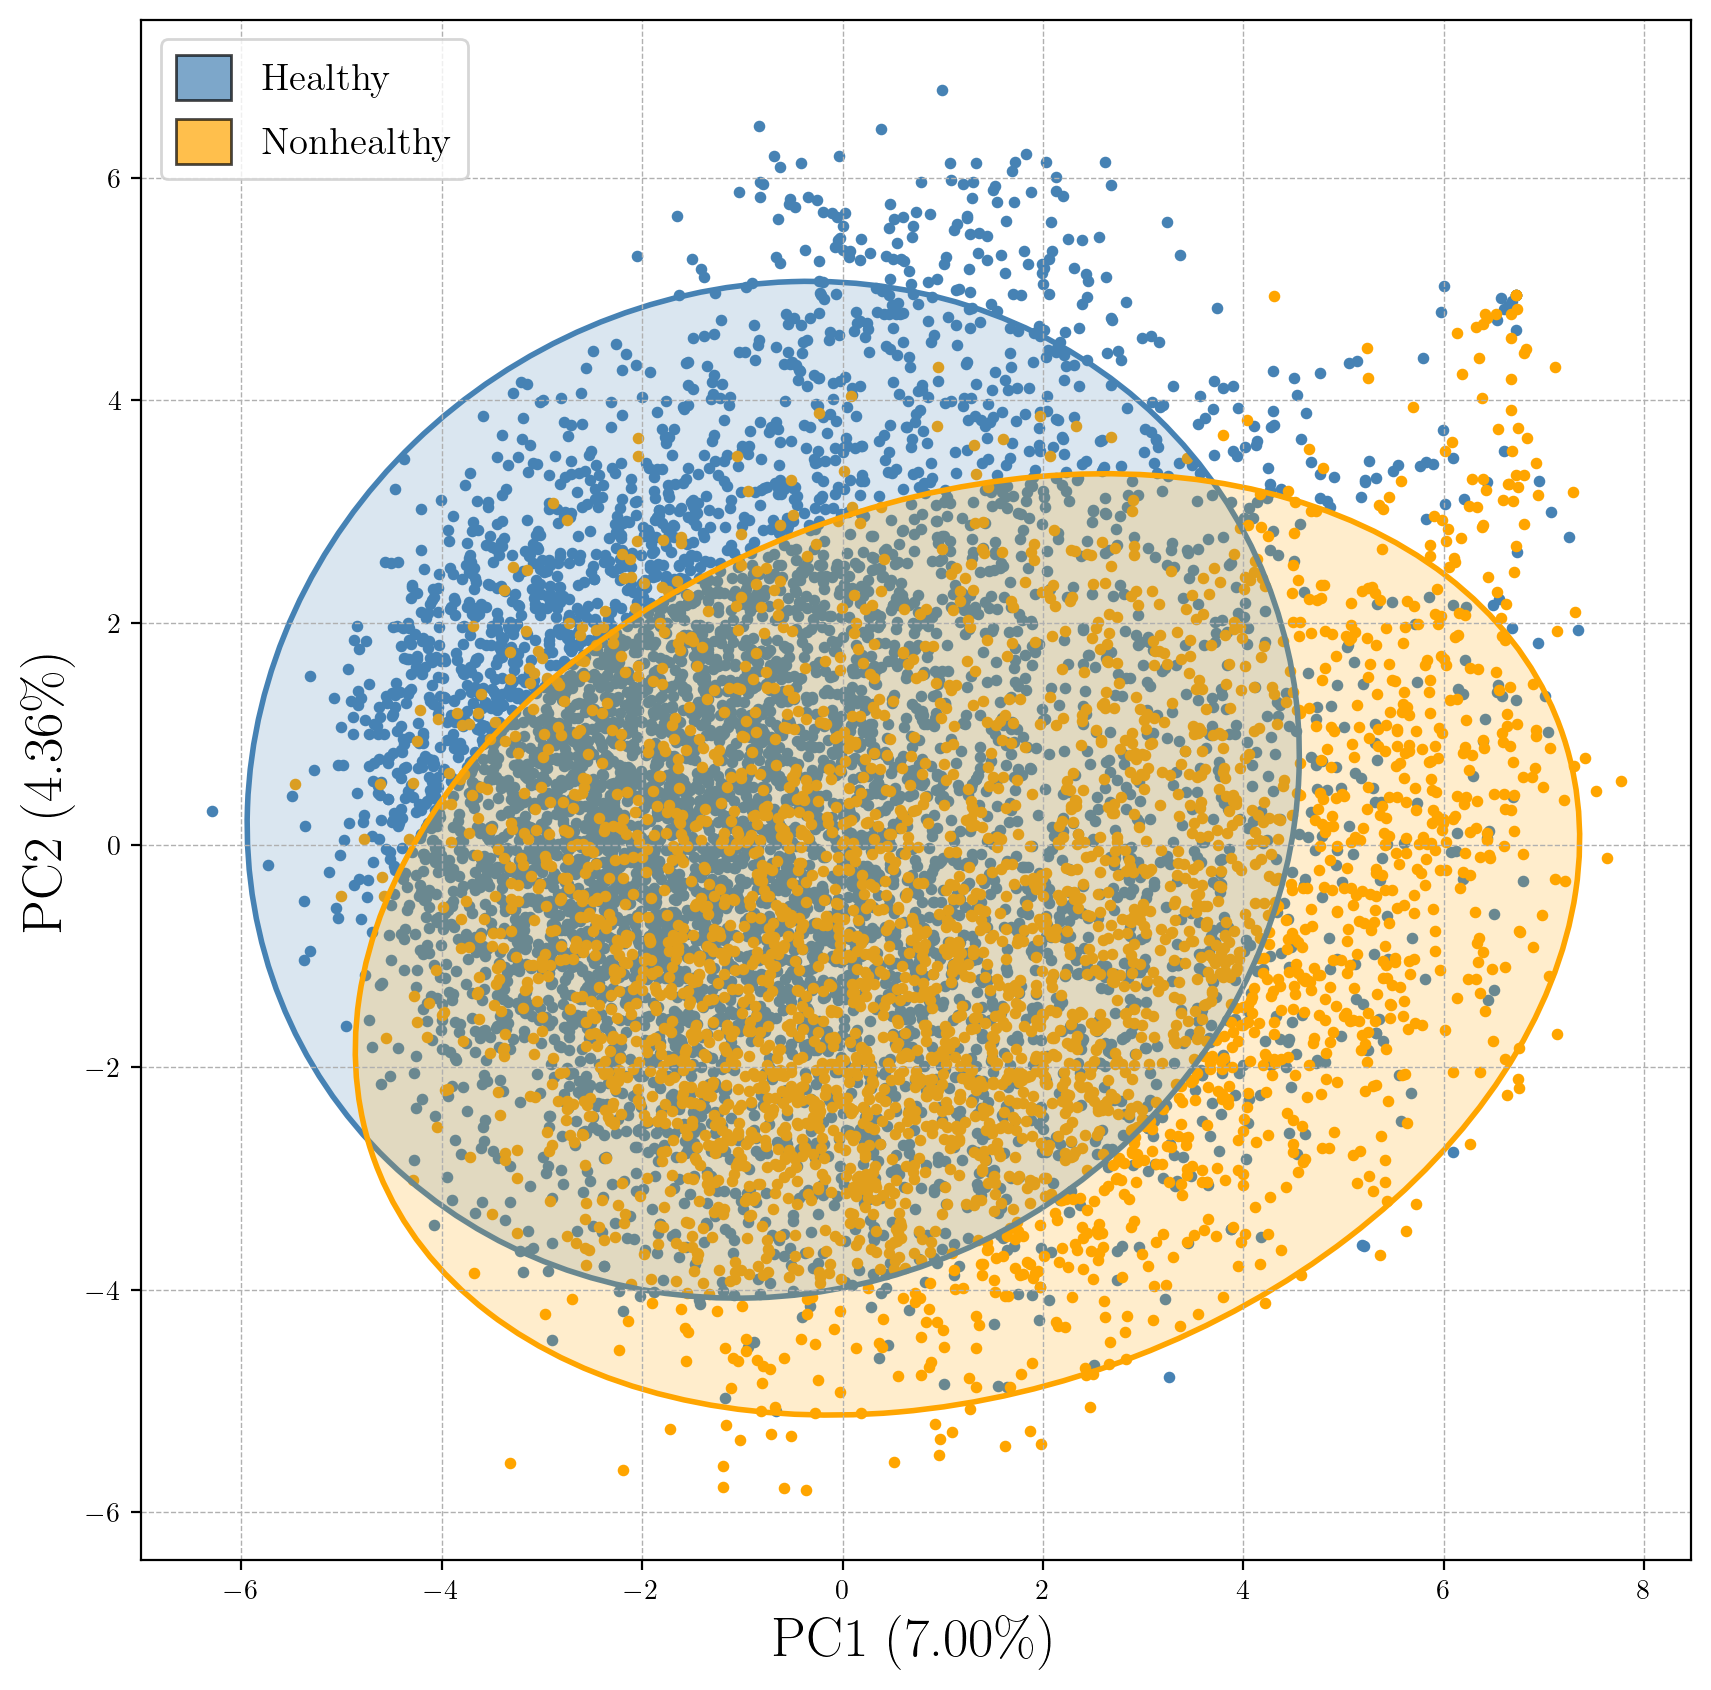

In [391]:
plot_pca(X, y)
# plt.savefig("pca.svg")

In [392]:
import matplotlib.ticker as mtick

def plot_study_performance(y, scores):
    plt.figure(figsize=(10, 10), dpi=200)
    study_bals = []
    for study in np.unique(scores.index.get_level_values(0)):
        try:
            y_study = y.loc[study]
            pred_study = scores.loc[study]
            study_bal = balanced_accuracy_score(y_study, pred_study > 0)
            study_bals.append(study_bal)
        except:
            print(f"{study} is not in retained samples")
    sns.histplot(data=study_bals, bins=20)
    plt.xticks(list(np.arange(0, 1, 0.1)) + [1])
    plt.tick_params(labelsize=20)
    plt.grid(axis="y", linestyle = '--', linewidth = 0.5)
    
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    plt.ylabel("Study Count", fontsize=25)
    plt.xlabel("Balanced Accuracy", fontsize=25)

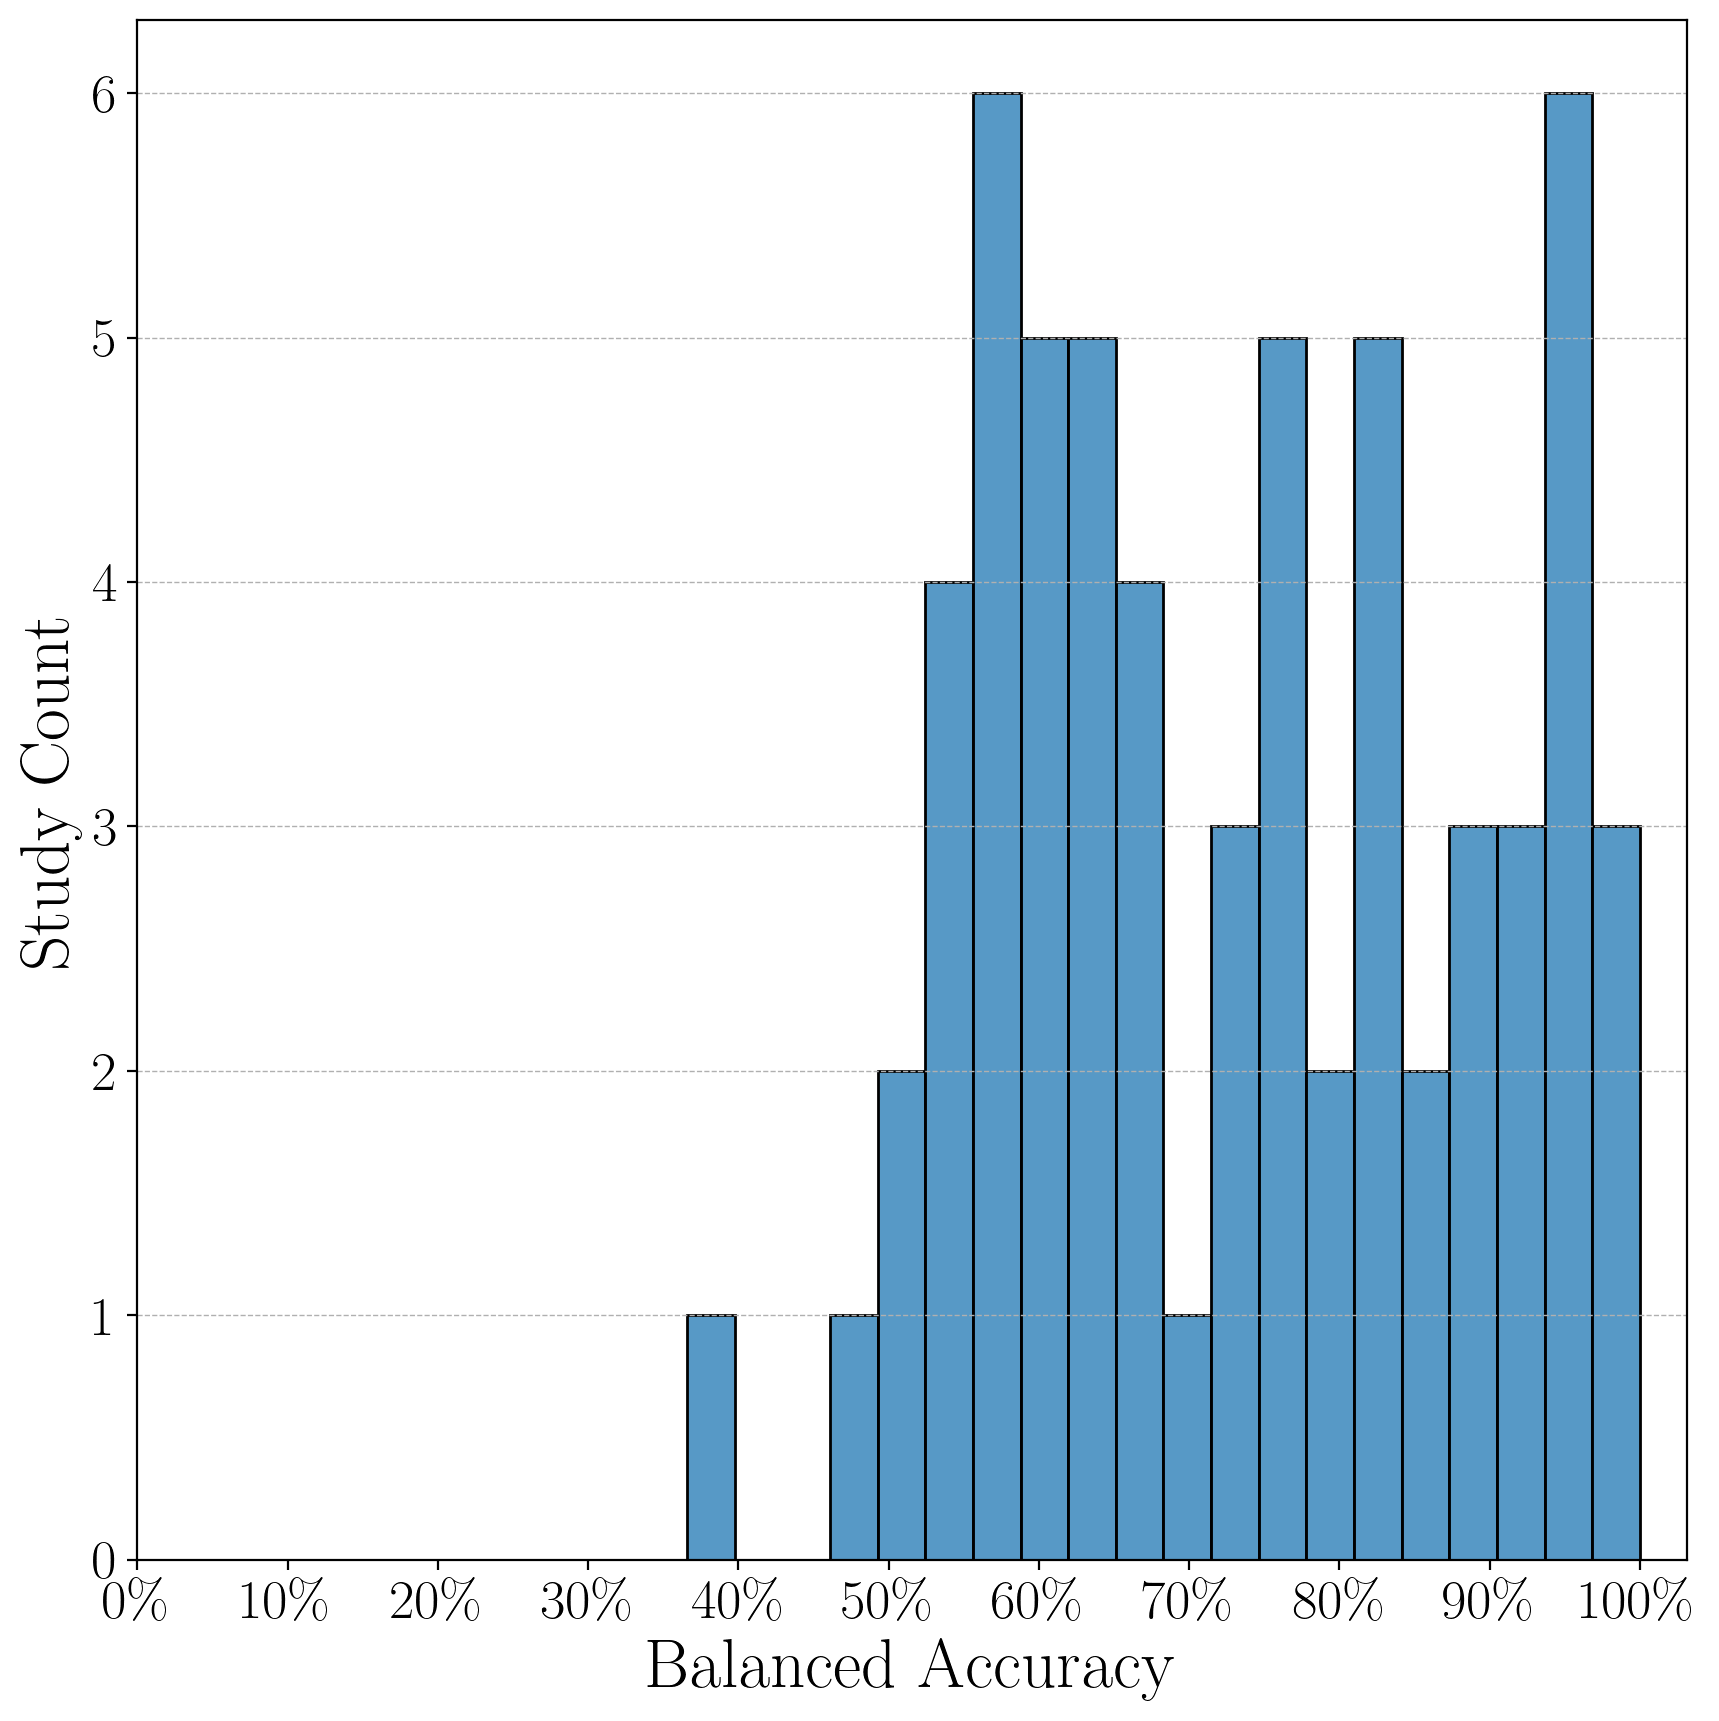

In [393]:
thresh = 0.1
idx = abs(GMHI2_scores.values) > thresh
plot_study_performance(y.iloc[idx], GMHI2_scores.iloc[idx])
# plt.savefig("study_performance_hist.svg")

In [394]:
richness = pd.DataFrame((X_species > cutoff).sum(axis=1), columns=["Species Richness"])

In [395]:
shannon = pd.DataFrame(np.sum((-X_species * np.log(X_species)).fillna(0), axis=1), columns=["Shannon Diversity"])

In [396]:
healthy_nonhealthy = raw[["PHENOTYPE:Healthy_Nonhealthy"]]
healthy_nonhealthy.columns = ["Health status"]
data = pd.concat([GMHI2_scores, GMHI_scores, healthy_nonhealthy, richness, shannon, ], axis=1)

In [1]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 6), dpi=200)
indices = ["GMHI2", "GMHI", "Shannon Diversity", "Species Richness"]
for ind, ax in zip(indices, axs):
    v = sns.violinplot(x="Health status", y=ind, data=data, ax=ax, 
                   palette={"Healthy" : "steelblue", "Nonhealthy" : "orange"})
    print(cliffs_delta(data[y.values.flatten()][ind], data[~y.values.flatten()][ind]))
    v.tick_params(labelsize=20)
    ax.yaxis.label.set_size(20)
    ax.set_xlabel("")
#     break
fig.subplots_adjust(wspace=0.4)
plt.savefig("violin.svg")    

NameError: name 'plt' is not defined

In [398]:
from cliffs_delta import cliffs_delta
print(cliffs_delta(data[y.values.flatten()]["GMHI2"], data[~y.values.flatten()]["GMHI2"]))
print(cliffs_delta(data[y.values.flatten()]["GMHI"], data[~y.values.flatten()]["GMHI"]))
print(cliffs_delta(data[y.values.flatten()]["Shannon Diversity"], data[~y.values.flatten()]["Shannon Diversity"]))
print(cliffs_delta(data[y.values.flatten()]["Species Richness"], data[~y.values.flatten()]["Species Richness"]))

(0.6404045281256315, 'large')
(0.5880360496809786, 'large')
(0.1595967929843096, 'small')
(-0.04880473110778158, 'negligible')


In [399]:
regularization = 0.03

# establish a cutoff threshold for presence/absence
cutoff = 0.00001

# instantiate the logistic regression classifier
clf = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=regularization, class_weight="balanced")
clf.fit(X > cutoff, y.values.flatten())

LogisticRegression(C=0.03, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [358]:
coef_df = pd.DataFrame(clf.coef_.T, index=[col.split("|")[-1] for col in X.columns], columns=["coef"])

In [368]:
coef_df.sort_values("coef", ascending=False).head(7)

,coef
s__Lactobacillus_ruminis,0.599337
s__Romboutsia_ilealis,0.466855
s__Bifidobacterium_catenulatum,0.357519
s__Ruminococcus_bicirculans,0.256916
s__Eubacterium_eligens,0.247379
s__Clostridium_sp_CAG_167,0.246477
s__Bifidobacterium_angulatum,0.240603


In [ ]:
s\_\_Lactobacillus\_ruminis &	0.599337\\
\hline
s\_\_Romboutsia\_ilealis &	0.466855\\
\hline
s\_\_Bifidobacterium\_catenulatum &	0.357519\\
\hline
s\_\_Ruminococcus\_bicirculans &	0.256916\\
\hline
s\_\_Eubacterium\_eligens &	0.247379\\
\hline
s\_\_Clostridium\_sp\_CAG\_167 &	0.246477\\
\hline
s\_\_Bifidobacterium\_angulatum &	0.240603\\
\hline

In [ ]:
s\_\_Streptococcus\_anginosus\_group &	-0.316349\\
\hline
s\_\_Streptococcus\_vestibularis &	-0.320378\\
\hline
s\_\_Dialister\_pneumosintes &	-0.381317\\
\hline
s\_\_Eubacterium\_sp\_CAG\_180 &	-0.448206\\
\hline
s\_\_Lactobacillus\_salivarius &	-0.471955\\
\hline
g\_\_Lachnoclostridium &	-0.556998\\
\hline
g\_\_Mogibacterium &	-0.684481\\
\hline

In [635]:
fname = "../../prebiotics_2022/merged_mp3.txt"

In [636]:
df = pd.read_csv(fname, delimiter="\t", header=1).T
df = df.rename(columns=df.iloc[0]).iloc[2:, :]
df = df.divide((100 - df["UNKNOWN"]), axis="rows")
df = df.drop(labels=["UNKNOWN"], axis=1)

In [638]:
to_add = list(set(X.columns) - set(df.columns))

In [639]:
zeros_df = pd.DataFrame(np.zeros((df.shape[0], len(to_add))), index=df.index, columns=to_add)
zeros_df

,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_argenteus,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_granulosa,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_farmeri,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__Podoviridae_unclassified|s__Pseudomonas_phage_Bf7,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Megamonas|s__Megamonas_rupellensis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_sp_D27,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Prolinoborus|s__Prolinoborus_fasciculus,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Alcaligenes,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Melissococcus,...,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_soli,k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_showae,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__T5virus|s__Yersinia_phage_phiR201,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Tymovirales|f__Betaflexiviridae|g__Capillovirus,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudogenitalium,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Ascoviridae|g__Ascovirus,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_formicicum,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Picornavirales|f__Picornaviridae|g__Enterovirus
IN24_1_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GS24_1_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NS24_2_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FS24_1_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NS0_1_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NS24_3_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XS24_1_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FL24_2_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FL24_3_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GS24_3_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [640]:
X_prebiotics = pd.concat([df, zeros_df], axis=1)[X.columns]
X_prebiotics

,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae,k__Archaea|p__Euryarchaeota|c__Thermoplasmata,...,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Hordeivirus|s__Barley_stripe_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cactus_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cucumber_green_mottle_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Paprika_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Pepper_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Tobacco_mild_green_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Deep_sea_thermophilic_phage_D6E,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Loktanella_phage_pCB2051_A,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Tetraselmis_viridis_virus_S1
IN24_1_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GS24_1_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NS24_2_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FS24_1_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NS0_1_metaphlan3,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NS24_3_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XS24_1_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FL24_2_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FL24_3_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GS24_3_metaphlan3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [670]:
X

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
GMHI-23  SAMEA3879547        0.019774                     0.019774   
         SAMEA3879551        0.000000                     0.000000   
         SAMEA3879543        0.003253                     0.003253   
         SAMEA3879565        0.008863                     0.008863   
         SAMEA3879546        0.000048                     0.000048   
...                               ...                          ...   
P140     SAMN07509557        0.000000                     0.000000   
         SAMN07509558        0.000000                     0.000000   
         SAMN07509546        0.000000                     0.000000   
         SAMN07509552        0.000000                     0.000000   
         SAMN07509921        0.000000                     0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
GMHI-23  SAMEA3879547                                            0.019774   
         SAMEA3879551                                            0.000000   
         SAMEA3879543                                            0.003253   
         SAMEA3879565                                            0.008863   
         SAMEA3879546                                            0.000048   
...                                                                   ...   
P140     SAMN07509557                                            0.000000   
         SAMN07509558                                            0.000000   
         SAMN07509546                                            0.000000   
         SAMN07509552                                            0.000000   
         SAMN07509921                                            0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
GMHI-23  SAMEA3879547                                               0.019774                      
         SAMEA3879551                                               0.000000                      
         SAMEA3879543                                               0.003253                      
         SAMEA3879565                                               0.008863                      
         SAMEA3879546                                               0.000048                      
...                                                                      ...                      
P140     SAMN07509557                                               0.000000                      
         SAMN07509558                                               0.000000                      
         SAMN07509546                                               0.000000                      
         SAMN07509552                                               0.000000                      
         SAMN07509921                                               0.000000                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
GMHI-23  SAMEA3879547                                               0.019774                                             
         SAMEA3879551                                               0.000000                                             
         SAMEA3879543                                               0.003253                                             
         SAMEA3879565                                               0.008863                                             
         SAMEA3879546                                               0.000048                  

In [643]:
regularization = 0.03

# establish a cutoff threshold for presence/absence
cutoff = 0.00001

# instantiate the logistic regression classifier
clf = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=regularization, class_weight="balanced")
clf.fit(X > cutoff, y.values.flatten())

values = clf.decision_function(X_prebiotics > cutoff)

In [644]:
GMHI2_scores = pd.DataFrame(values, index=X_prebiotics.index)
GMHI2_scores

,0
IN24_1_metaphlan3,0.688926
GS24_1_metaphlan3,0.691593
NS24_2_metaphlan3,-0.599323
FS24_1_metaphlan3,-0.016143
NS0_1_metaphlan3,0.054332
NS24_3_metaphlan3,-0.709853
XS24_1_metaphlan3,0.090429
FL24_2_metaphlan3,-0.382121
FL24_3_metaphlan3,-0.606658
GS24_3_metaphlan3,0.571372


In [646]:
GMHI2_scores.sort_index()

,0
FL24_1_metaphlan3,-0.576239
FL24_2_metaphlan3,-0.382121
FL24_3_metaphlan3,-0.606658
FS24_1_metaphlan3,-0.016143
FS24_2_metaphlan3,0.432063
FS24_3_metaphlan3,0.432063
GS24_1_metaphlan3,0.691593
GS24_2_metaphlan3,0.691593
GS24_3_metaphlan3,0.571372
IN24_1_metaphlan3,0.688926
